# Brief Tutorial on Extracting Optuna Study
This notebook is intended to introduce the minimal functions needed to perform the GWOT optimization.    
For most users, using `align_representations.py`, as demonstrated in our main tutorial `tutorial.ipynb`, will be sufficient.   
However, this tutorial is intended for some users who want to understand how Optuna is used in this toolbox and customize the optimization process by using Optuna on their own.    

This notebook briefly demonstrates how to :
1. Use `opt.run_study` to create an Optuna study.   
2. Extract the `best_trial` from the study.    

Please make sure that you have worked through the main tutorial (`tutorial.ipynb`) before diving into this one, as this tutorial focuses only on specific objectives and assumes familiarity with the main concepts.

In [15]:
# Standard Library
import os
import pickle as pkl
import sys

sys.path.append(os.path.join(os.getcwd(), '../'))

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
# import pymysql
import scipy.io
import seaborn as sns
import torch
from sqlalchemy import URL, create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database

# First Party Library
from src.gw_alignment import GW_Alignment
from src.utils.gw_optimizer import load_optimizer
from src.utils.init_matrix import InitMatrix
# os.chdir(os.path.dirname(__file__))


## Step:1 load data
Here we use the `color` data for demonstaration.   
`color`: human similarity judgements of 93 colors for 5 paricipants groups

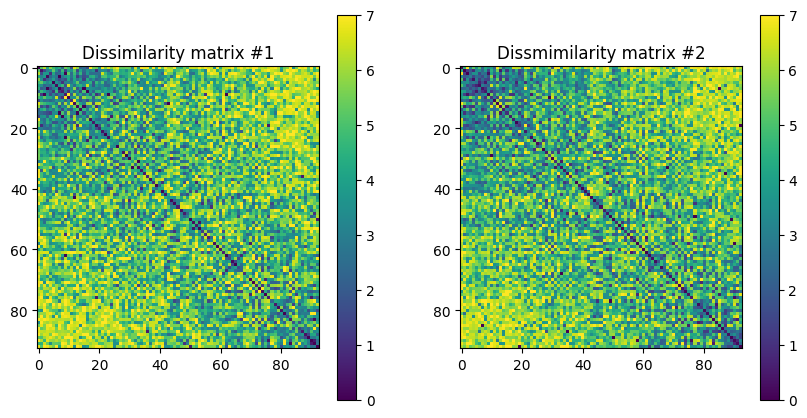

In [16]:
data_path = '../data/color/num_groups_5_seed_0_fill_val_3.5.pickle'
with open(data_path, "rb") as f:
    data = pkl.load(f)
sim_mat_list = data["group_ave_mat"]
C1 = sim_mat_list[1]
C2 = sim_mat_list[2]

# show dissimilarity matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(C1, cmap='viridis')
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(C2, cmap='viridis')
cbar2 = fig.colorbar(im2, ax=axes[1])

axes[0].set_title('Dissimilarity matrix #1')
axes[1].set_title('Dissmimilarity matrix #2')
plt.show()

## Step:2 set the parameter used for computing and saving the results

In [17]:
# set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
device = 'cpu'
to_types = 'numpy'

# Set the range of epsilon
eps_list = [1e-2, 1e-1]
# eps_list = [1e-2, 1e-1, 1e-3]

eps_log = True # use log scale if True

# Set the params for the trial of optimize and max iteration for gw alignment computation
# set the number of trials, i.e., the number of epsilon values tested in optimization: default : 20
num_trial = 20

# the maximum number of iteration for GW optimization: default: 1000
max_iter = 200

# choose sampler
sampler_name = 'tpe'

# choose pruner
pruner_name = 'hyperband'
pruner_params = {'n_startup_trials': 1, 'n_warmup_steps': 2, 'min_resource': 2, 'reduction_factor' : 3}

# initialization of transportation plan
# 'uniform': uniform matrix, 'diag': diagonal matrix', random': random matrix, 'permutation': permutation matrix
init_mat_plan = 'random'

# the number of random initial matrices for 'random' or 'permutation' options：default: 100
n_iter = 1

## Set the parameters for GW alignment computation 
# please choose the method of sinkhorn implemented by POT (URL : https://pythonot.github.io/gen_modules/ot.bregman.html#id87). For using GPU, "sinkhorn_log" is recommended.
sinkhorn_method='sinkhorn'

# user can define the dtypes both for numpy and torch, "float(=float32)" or "double(=float64)". For using GPU with "sinkhorn", double is storongly recommended.
data_type = "double"

### Set the filename and folder name for saving optuna results  
filename is also treated as optuna study_name

In [18]:
filename = 'test'
save_path = '../results/tutorial_minimal/' + filename + '/' + sampler_name

### Set the database URL to store the optimization results.  

The URL notation should follow the SQLAlchemy documentation:   
https://docs.sqlalchemy.org/en/20/core/engines.html  

To use remote databases, you need to start the database server beforehand. For detailed instruction, please refer to the Optuna official tutorial:  
https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html  

When using SQLite, the database file is automatically created, so you only need to set the URL.

In [19]:
# Specify the RDB to use for distributed calculations
db_params={"drivername": "sqlite"} # SQLite
# db_params={"drivername": "mysql+pymysql", "username": "root", "password": "****", "host": "localhost"} # MySQL

if db_params["drivername"] == "sqlite":
    storage = "sqlite:///" + save_path +  '/' + filename + '.db'
else:
    # Generate the URL for the database. Syntax differs for SQLite and others.
    storage = URL.create(database=filename, **db_params).render_as_string(hide_password=False)

## Step:3 Perform GW Alignment

In [20]:
# generate instance solves gw_alignment　
test_gw = GW_Alignment(
    C1, 
    C2, 
    save_path, 
    max_iter = max_iter, 
    n_iter = n_iter, 
    to_types = to_types,
    data_type = data_type,
    sinkhorn_method = sinkhorn_method,    
)

In [21]:
# generate instance optimize gw_alignment　
opt = load_optimizer(
    save_path=save_path,
    filename=filename,
    storage=storage,
    init_mat_plan=init_mat_plan,
    n_iter = n_iter,
    num_trial = num_trial,
    n_jobs = 1,    
    method = 'optuna',
    sampler_name = sampler_name,
    pruner_name = pruner_name,
    pruner_params = pruner_params,
)

### Compute GW Alignment

In [22]:
### Running the Optimization using `opt.run_study`
# 2. run optimzation
study = opt.run_study(
    test_gw,
    device,
    seed=42,
    init_mat_plan=init_mat_plan,
    eps_list=eps_list,
    eps_log=eps_log,
    search_space=None,
)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/oizumi/GitHub/GW_methods/.venv/lib/python3.10/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
[I 2023-08-10 16:35:12,668] Trial 4 finished with value: 2.0401389644483903 and parameters: {'eps': 0.023688639503640783}. Best is trial 0 with value: 1.8578074805929752.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:35:16,026] Trial 5 finished with value: 2.2237345892656863 and parameters: {'eps': 0.08927180304353628}. Best is trial 0 with value: 1.8578074805929752.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:35:21,139] Trial 6 finished with value: 1.7026836749688725 and parameters: {'eps': 0.05395030966670229}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:35:28,904] Trial 7 finished with value: 2.046729479982014 and parameters: {'eps': 0.03968793330444373}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

/home/oizumi/GitHub/GW_methods/.venv/lib/python3.10/site-packages/ot/bregman.py:502: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/home/oizumi/GitHub/GW_methods/.venv/lib/python3.10/site-packages/ot/bregman.py:510: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/oizumi/GitHub/GW_methods/.venv/lib/python3.10/site-packages/ot/bregman.py:502: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
[I 2023-08-10 16:35:29,074] Trial 8 pruned. All iteration was failed with parameters: {'eps': 0.014322493718230255, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

/home/oizumi/GitHub/GW_methods/.venv/lib/python3.10/site-packages/ot/bregman.py:510: UserWarning: Warning: numerical errors at iteration 4
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
[I 2023-08-10 16:35:36,334] Trial 9 finished with value: 2.090454302726295 and parameters: {'eps': 0.01432169828911152}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:35:43,778] Trial 10 finished with value: 1.9521261807108732 and parameters: {'eps': 0.05987384184453169}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:35:51,186] Trial 11 finished with value: 1.8431248385168182 and parameters: {'eps': 0.02454813108132615}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:07,415] Trial 12 finished with value: 2.1919522835769025 and parameters: {'eps': 0.026165275267351643}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:07,993] Trial 13 pruned. All iteration was failed with parameters: {'eps': 0.01071210093531734, 'initialize': 'random'}


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:15,900] Trial 14 finished with value: 1.871770346673765 and parameters: {'eps': 0.03396000711158808}. Best is trial 6 with value: 1.7026836749688725.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:23,395] Trial 15 finished with value: 1.6518997501105666 and parameters: {'eps': 0.0541001344481548}. Best is trial 15 with value: 1.6518997501105666.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:31,240] Trial 16 finished with value: 1.9953571360329834 and parameters: {'eps': 0.05956653916972638}. Best is trial 15 with value: 1.6518997501105666.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:38,566] Trial 17 finished with value: 2.029197076067024 and parameters: {'eps': 0.07287093022241573}. Best is trial 15 with value: 1.6518997501105666.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:46,213] Trial 18 finished with value: 1.8460035502530294 and parameters: {'eps': 0.045738523491216945}. Best is trial 15 with value: 1.6518997501105666.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:50,642] Trial 19 finished with value: 1.8789747326366533 and parameters: {'eps': 0.09849803735153118}. Best is trial 15 with value: 1.6518997501105666.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:36:54,714] Trial 20 finished with value: 1.6286923976369923 and parameters: {'eps': 0.07226475984628108}. Best is trial 20 with value: 1.6286923976369923.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:37:02,514] Trial 21 finished with value: 2.3681330939211986 and parameters: {'eps': 0.0680564103047699}. Best is trial 20 with value: 1.6286923976369923.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:37:10,323] Trial 22 finished with value: 1.8580966115779107 and parameters: {'eps': 0.04875672318975956}. Best is trial 20 with value: 1.6286923976369923.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-08-10 16:37:17,975] Trial 23 finished with value: 2.177414326081445 and parameters: {'eps': 0.06689230183581422}. Best is trial 20 with value: 1.6286923976369923.


## Step:4 View the result

In [23]:
### View Results
display(study.trials_dataframe().sort_values('params_eps'))

,number,value,datetime_start,datetime_complete,duration,params_eps,user_attrs_best_acc,user_attrs_best_iter,user_attrs_best_seed,user_attrs_source_size,user_attrs_target_size,state
13,13,NaN,2023-08-10 16:36:07.421958,2023-08-10 16:36:07.908084,0 days 00:00:00.486126,0.010712,NaN,NaN,NaN,93,93,PRUNED
9,9,2.090454,2023-08-10 16:35:29.080011,2023-08-10 16:35:36.301581,0 days 00:00:07.221570,0.014322,0.010753,0.0,8994.0,93,93,COMPLETE
8,8,NaN,2023-08-10 16:35:28.909762,2023-08-10 16:35:29.054247,0 days 00:00:00.144485,0.014322,NaN,NaN,NaN,93,93,PRUNED
0,0,1.857807,2023-08-10 16:34:23.476649,2023-08-10 16:34:30.774861,0 days 00:00:07.298212,0.023689,0.053763,0.0,73548.0,93,93,COMPLETE
4,4,2.040139,2023-08-10 16:35:05.093601,2023-08-10 16:35:12.632869,0 days 00:00:07.539268,0.023689,0.053763,0.0,18484.0,93,93,COMPLETE
11,11,1.843125,2023-08-10 16:35:43.784800,2023-08-10 16:35:51.152968,0 days 00:00:07.368168,0.024548,0.129032,0.0,70249.0,93,93,COMPLETE
12,12,2.191952,2023-08-10 16:35:51.192490,2023-08-10 16:36:07.334721,0 days 00:00:16.142231,0.026165,0.010753,0.0,94726.0,93,93,COMPLETE
14,14,1.871770,2023-08-10 16:36:08.005102,2023-08-10 16:36:15.866976,0 days 00:00:07.861874,0.033960,0.043011,0.0,46128.0,93,93,COMPLETE
7,7,2.046729,2023-08-10 16:35:21.144483,2023-08-10 16:35:28.873965,0 days 00:00:07.729482,0.039688,0.032258,0.0,56520.0,93,93,COMPLETE
3,3,1.873639,2023-08-10 16:34:36.976596,2023-08-10 16:34:44.449109,0 days 00:00:07.472513,0.039688,0.096774,0.0,68675.0,93,93,COMPLETE


FrozenTrial(number=20, state=TrialState.COMPLETE, values=[1.6286923976369923], datetime_start=datetime.datetime(2023, 8, 10, 16, 36, 50, 648697), datetime_complete=datetime.datetime(2023, 8, 10, 16, 36, 54, 679978), params={'eps': 0.07226475984628108}, user_attrs={'best_acc': 0.43010752688172044, 'best_iter': 0, 'best_seed': 34979, 'source_size': 93, 'target_size': 93}, system_attrs={}, intermediate_values={0: 1.6286923976369923}, distributions={'eps': FloatDistribution(high=0.1, log=True, low=0.01, step=None)}, trial_id=21, value=None)


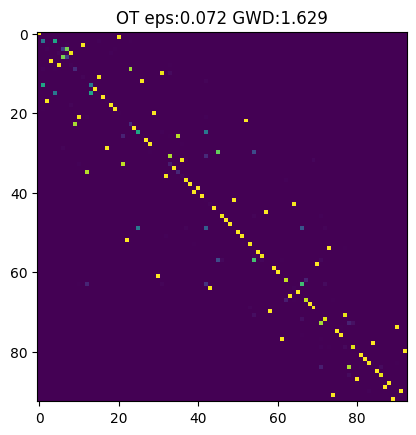

In [28]:
### Extracting the Best Trial from the Study
df_trial = study.trials_dataframe()
best_trial = study.best_trial
print(best_trial)

# extracting optimized epsilon, GWD from best_trial
eps_opt = best_trial.params['eps']
GWD_opt = best_trial.values[0]

# load the opitimized transportation plan from the saved file
if to_types == 'numpy':
    OT = np.load(save_path+f'/gw_{best_trial.number}.npy')
elif to_types == 'torch':
    OT = torch.load(save_path+f'/gw_{best_trial.number}.pt')
    OT = OT.to('cpu').numpy()

# plot the optimal transportation plan
plt.imshow(OT)
plt.title(f'OT eps:{eps_opt:.3f} GWD:{GWD_opt:.3f}')
plt.show()


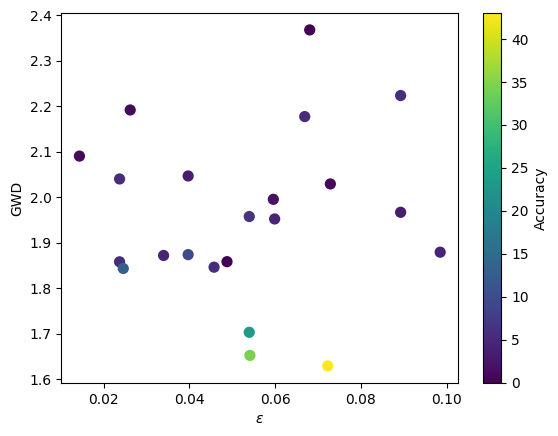

In [26]:
# figure plotting epsilon as x-axis and GWD as y-axis
df_trial = study.trials_dataframe()

plt.scatter(df_trial['params_eps'], df_trial['value'], s = 50, c=df_trial['user_attrs_best_acc'] * 100, cmap='viridis')
plt.xlabel('$\epsilon$')
plt.ylabel('GWD')
plt.colorbar(label='Accuracy')
plt.show()

accuracy=43.01075268817204%


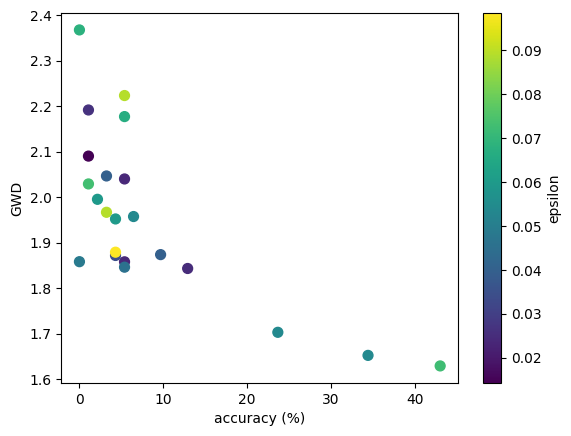

In [29]:
# evaluate accuracy of unsupervised alignment
max_indices = np.argmax(OT, axis=1)
accuracy = np.mean(max_indices == np.arange(OT.shape[0])) * 100
print(f'accuracy={accuracy}%')


#　figure plotting GWD as x-axis and accuracy as y-axis
plt.scatter(df_trial['user_attrs_best_acc'] * 100, df_trial['value'], s = 50, c= df_trial['params_eps'])
plt.xlabel('accuracy (%)')
plt.ylabel('GWD')
plt.colorbar(label='epsilon')
plt.show()